In this exploration notebook, we shall try to uncover the basic information about the dataset which will help us build our models / features. 

Let us first import the necessary modules.

In [94]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

Loading the training dataset and looking at the top few rows.

In [2]:
train_df = pd.read_json("input/train.json")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


Wow. This dataset looks interesting. It has numerical features, categorical features, date feature, text features and image features.  

Let us load the test data as well and check the number of rows in train and test to start with.

In [3]:
test_df = pd.read_json("input/test.json")
test_df.info()
print("Train Rows : ", train_df.shape[0])
print("Test Rows : ", test_df.shape[0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 14 columns):
bathrooms          74659 non-null float64
bedrooms           74659 non-null int64
building_id        74659 non-null object
created            74659 non-null object
description        74659 non-null object
display_address    74659 non-null object
features           74659 non-null object
latitude           74659 non-null float64
listing_id         74659 non-null int64
longitude          74659 non-null float64
manager_id         74659 non-null object
photos             74659 non-null object
price              74659 non-null int64
street_address     74659 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB
Train Rows :  49352
Test Rows :  74659


** Cleaning Coordinates **

In [89]:
joint = pd.concat([train_df,test_df],axis=0)

# New York City Center Coords
ny_lat = 40.785091
ny_lon = -73.968285


print(joint[joint.distance_from_NY > 0.5].shape)
print(joint[joint.latitude < 40].shape)
print(joint[joint.longitude < -75].shape)

(70, 20)
(35, 20)
(8, 20)


In [103]:
mask = ((joint.longitude == 0) | (joint.latitude == 0) | (joint.latitude < 40) | (joint.longitude < -75))
missingCoords = joint[mask]
missingGeoms = (missingCoords.street_address + ' New York').apply(geocoder.google)

joint.loc[mask, 'latitude'] = missingGeoms.apply(lambda x: x.lat)
joint.loc[mask, 'longitude'] = missingGeoms.apply(lambda x: x.lng)
joint['distance_from_NY'] = np.sqrt((joint.longitude-ny_lon)**2 + (joint.latitude-ny_lat)**2)

<function matplotlib.pyplot.show>

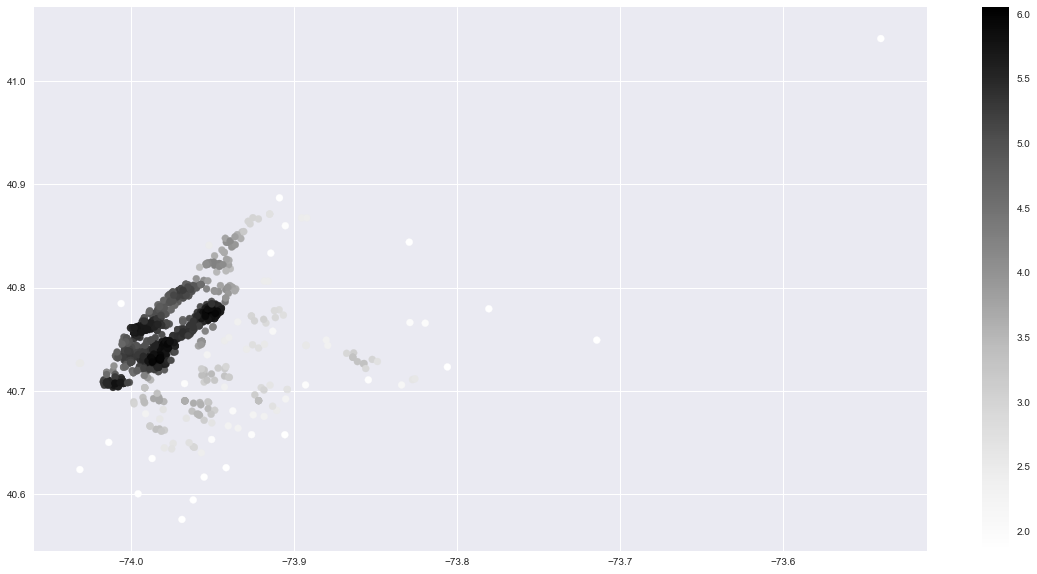

In [173]:
coords = pd.read_csv('code/coordinates.csv')
from sklearn.neighbors.kde import KernelDensity
cc = coords[['lat_fixed','lon_fixed']][0:1000]
kde = KernelDensity(kernel='gaussian', bandwidth=5e-3).fit(cc)
cc['res'] = kde.score_samples(cc)

plt.figure(figsize=(20,10))
plt.scatter(cc.lon_fixed,cc.lat_fixed,c=cc.res) 
plt.colorbar()
plt.show

In [162]:
cc.describe()

,lat_fixed,lon_fixed,res
count,1000.000000,1000.000000,1000.000000
mean,40.750876,-73.970740,4.943896
std,0.040430,0.034350,1.082288
min,40.575700,-74.031500,1.851002
25%,40.728300,-73.991400,4.634819
50%,40.751800,-73.978050,5.338850
75%,40.773900,-73.954775,5.722128
max,41.041200,-73.540000,6.052866


**Target Variable**

Before delving more into the features, let us first have a look at the target variable 'interest level'

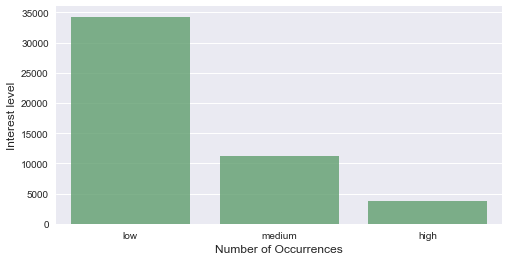

In [4]:
int_level = train_df['interest_level'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(int_level.index, int_level.values, alpha=0.8, color=color[1])
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Interest level', fontsize=12)
plt.show()

Interest level is low for most of the cases followed by medium and then high which makes sense.

Now let us start looking into the numerical features present in the dataset. Numerical features are

 - bathrooms
 - bedrooms
 - price
 - latitude
 - longitude

The last two are actually not numerical variables, but for now let us just consider it to be numerical.

**Bathrooms:**

Let us first start with bathrooms.

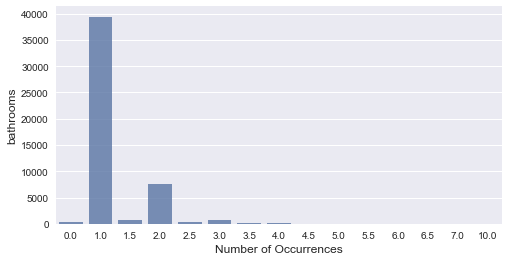

In [5]:
cnt_srs = train_df['bathrooms'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('bathrooms', fontsize=12)
plt.show()


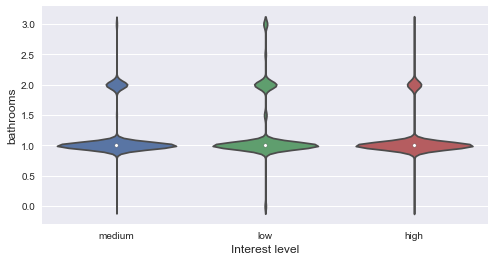

In [6]:
train_df['bathrooms'].ix[train_df['bathrooms']>3] = 3
plt.figure(figsize=(8,4))
sns.violinplot(x='interest_level', y='bathrooms', data=train_df)
plt.xlabel('Interest level', fontsize=12)
plt.ylabel('bathrooms', fontsize=12)
plt.show()

Looks like evenly distributed across the interest levels. Now let us look at the next feature 'bedrooms'.

**Bedrooms:**

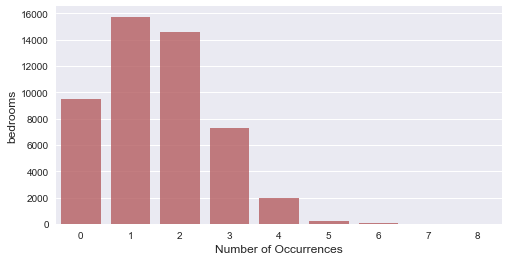

In [7]:
cnt_srs = train_df['bedrooms'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('bedrooms', fontsize=12)
plt.show()

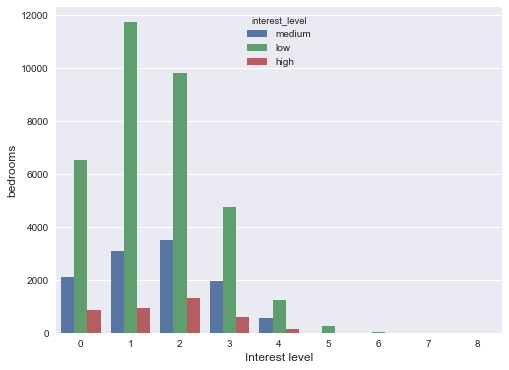

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(x='bedrooms', hue='interest_level', data=train_df)
plt.xlabel('Interest level', fontsize=12)
plt.ylabel('bedrooms', fontsize=12)
plt.show()

**Price:**

Now let us look at the price variable distribution.

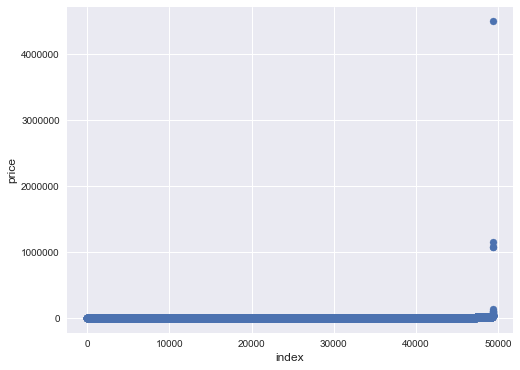

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

Looks like there are some outliers in this feature. So let us remove them and then plot again.

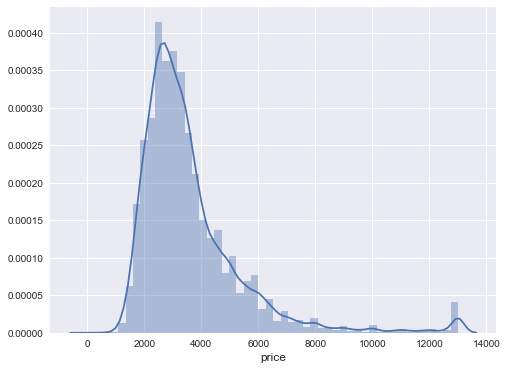

In [10]:
ulimit = np.percentile(train_df.price.values, 99)
train_df['price'].ix[train_df['price']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(train_df.price.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

The distribution is right skewed as we can see.

Now let us look at the latitude and longitude variables.

**Latitude & Longitude:**

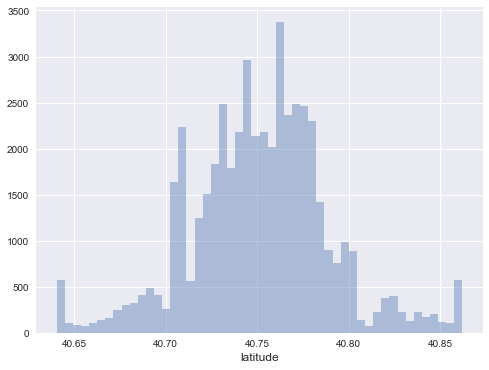

In [11]:
llimit = np.percentile(train_df.latitude.values, 1)
ulimit = np.percentile(train_df.latitude.values, 99)
train_df['latitude'].ix[train_df['latitude']<llimit] = llimit
train_df['latitude'].ix[train_df['latitude']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(train_df.latitude.values, bins=50, kde=False)
plt.xlabel('latitude', fontsize=12)
plt.show()

So the latitude values are primarily between 40.6 and 40.9. Now let us look at the longitude values.

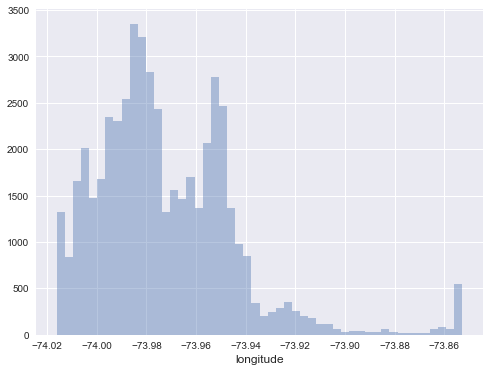

In [12]:
llimit = np.percentile(train_df.longitude.values, 1)
ulimit = np.percentile(train_df.longitude.values, 99)
train_df['longitude'].ix[train_df['longitude']<llimit] = llimit
train_df['longitude'].ix[train_df['longitude']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(train_df.longitude.values, bins=50, kde=False)
plt.xlabel('longitude', fontsize=12)
plt.show()

The longitude values range between -73.8 and -74.02. So the data corresponds to the **New York City**.

Now let us plot the same in a map. Thanks to this [kernel][1] by Dotman.


  [1]: https://www.kaggle.com/dotman/d/fivethirtyeight/uber-pickups-in-new-york-city/data-exploration-and-visualization

In [13]:
# from mpl_toolkits.basemap import Basemap
# from matplotlib import cm

# west, south, east, north = -74.02, 40.64, -73.85, 40.86

# fig = plt.figure(figsize=(14,10))
# ax = fig.add_subplot(111)
# m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
#             llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='i')
# x, y = m(train_df['longitude'].values, train_df['latitude'].values)
# m.hexbin(x, y, gridsize=200,
#          bins='log', cmap=cm.YlOrRd_r);

** Clustering by coordinates: **

In [14]:
# joint = pd.concat([train_df,test_df],axis=0)
# X = np.array([list(a) for a in zip(joint.latitude,joint.longitude)])

In [15]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# range_n_clusters = [50,100,200]
# for n_clusters in range_n_clusters:
#     kmeans = KMeans(n_clusters=n_clusters, random_state=0)    
#     cluster_labels = kmeans.fit_predict(X)
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

**Created:**

Now let us look at the date column 'created' 

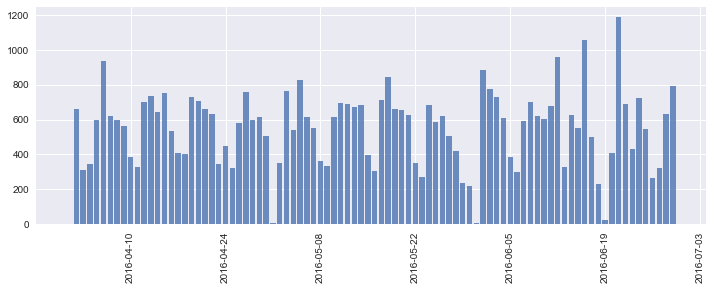

In [16]:
train_df["created"] = pd.to_datetime(train_df["created"])
train_df["date_created"] = train_df["created"].dt.date
cnt_srs = train_df['date_created'].value_counts()


plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.bar(cnt_srs.index, cnt_srs.values, alpha=0.8)
ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.show()


So we have data from April to June 2016 in our train set. Now let us look at the test set as well and see if they are also from the same date range. 


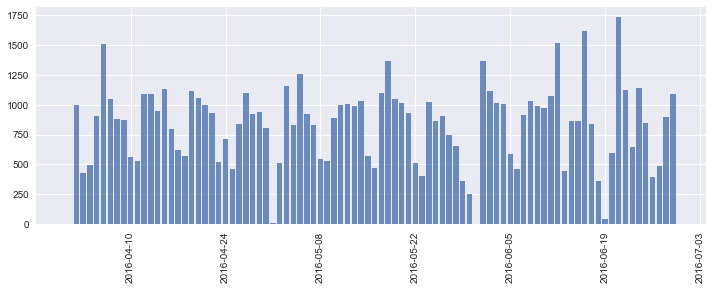

In [17]:
test_df["created"] = pd.to_datetime(test_df["created"])
test_df["date_created"] = test_df["created"].dt.date
cnt_srs = test_df['date_created'].value_counts()

plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.bar(cnt_srs.index, cnt_srs.values, alpha=0.8)
ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.show()

Looks very similar to the train set dates and so we are good to go.!

We shall also look at the hour-wise listing trend (Just for fun)

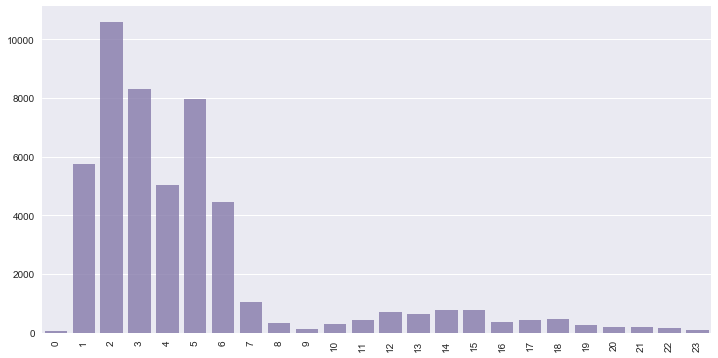

In [18]:
train_df["hour_created"] = train_df["created"].dt.hour
cnt_srs = train_df['hour_created'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.show()

Looks like listings are created during the early hours of the day (1 to 7am). May be that is when the traffic is less and so the updates are happening.

Now let us look at some of the categorical variables.

**Display Address:**

Ads that appear less than 2 times: 63.22%
Ads that appear less than 10 times: 89.6%
Ads that appear less than 50 times: 97.73%
Ads that appear less than 100 times: 99.26%
Ads that appear less than 500 times: 100.0%


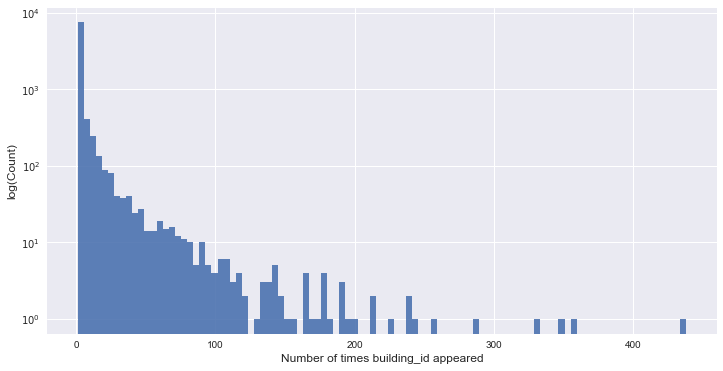

In [19]:
cnt_srs = train_df.groupby('display_address')['display_address'].count()

for i in [2, 10, 50, 100, 500]:
    print('Ads that appear less than {} times: {}%'.format(i, round((cnt_srs < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(cnt_srs.values, bins=100, log=True, alpha=0.9)
plt.xlabel('Number of times building_id appeared', fontsize=12)
plt.ylabel('log(Count)', fontsize=12)
plt.show()

Most of the display addresses occur less than 100 times in the given dataset. None of the display address occur more than 500 times.

**Number of Photos:**

This competition also has a huge database of photos of the listings. To start with, let us look at the number of photos given for listings.

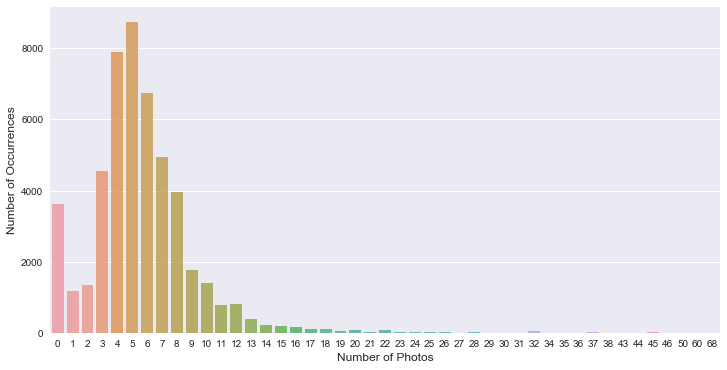

In [20]:
train_df["num_photos"] = train_df["photos"].apply(len)
cnt_srs = train_df['num_photos'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Number of Photos', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

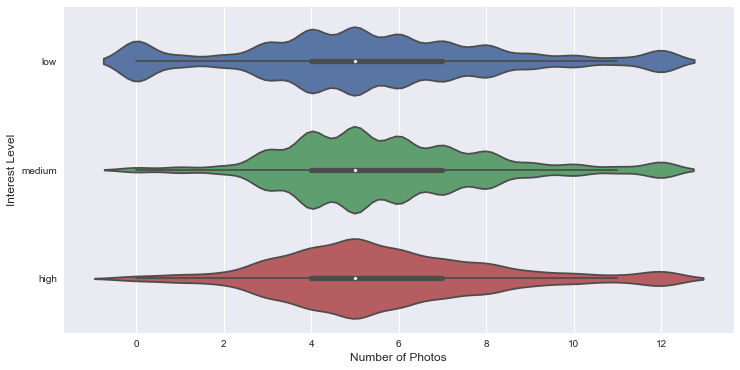

In [21]:
train_df['num_photos'].ix[train_df['num_photos']>12] = 12
plt.figure(figsize=(12,6))
sns.violinplot(x="num_photos", y="interest_level", data=train_df, order =['low','medium','high'])
plt.xlabel('Number of Photos', fontsize=12)
plt.ylabel('Interest Level', fontsize=12)
plt.show()

Let us now look at the number of features variable and see its distribution.

**Number of features:**

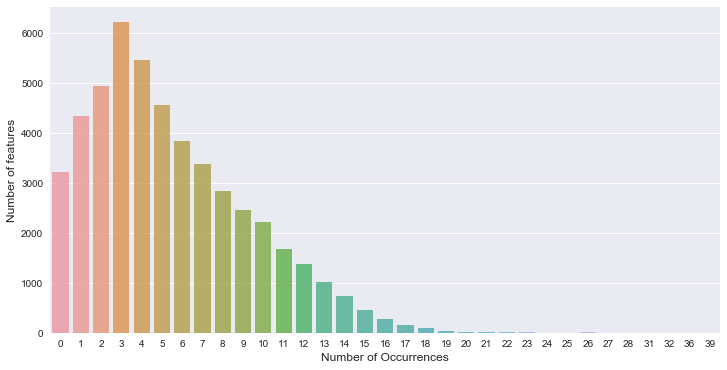

In [22]:
train_df["num_features"] = train_df["features"].apply(len)
cnt_srs = train_df['num_features'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Number of features', fontsize=12)
plt.show()

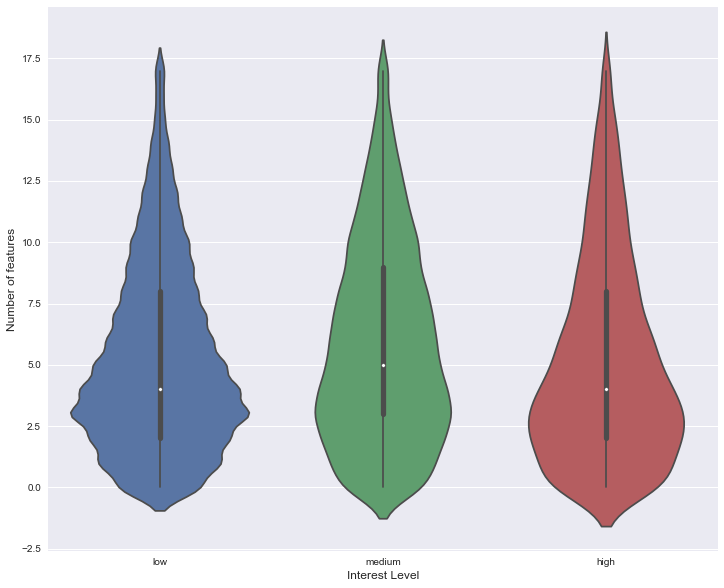

In [23]:
train_df['num_features'].ix[train_df['num_features']>17] = 17
plt.figure(figsize=(12,10))
sns.violinplot(y="num_features", x="interest_level", data=train_df, order =['low','medium','high'])
plt.xlabel('Interest Level', fontsize=12)
plt.ylabel('Number of features', fontsize=12)
plt.show()

**Word Clouds:**

Next we shall look into some for the text features.

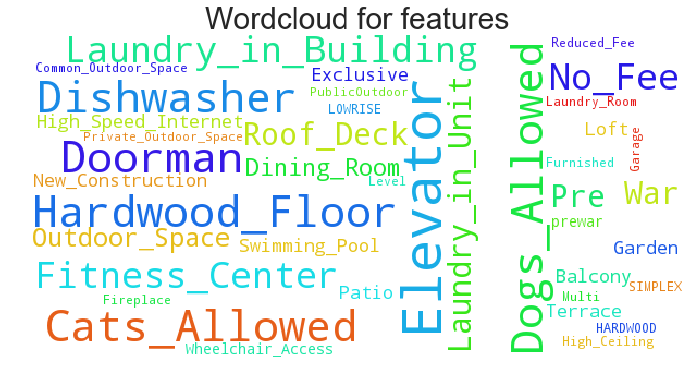

In [26]:
from wordcloud import WordCloud

text = ''
for ind, row in train_df.iterrows():
    for feature in row['features']:
        text = " ".join([text, "_".join(feature.strip().split(" "))])
text = text.strip()

plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=50, max_words=40).generate(text)
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Wordcloud for features", fontsize=30)
plt.axis("off")
plt.show()

**Map **

In [113]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from geopandas.tools import sjoin
from shapely.geometry import shape

points = joint[['longitude','latitude']]
points['geometry'] = points.apply(lambda x: Point(x.longitude,x.latitude),axis=1)
PointsGeodataframe = gpd.GeoDataFrame(points)
PolygonsGeodataframe = GeoDataFrame.from_file('input/neighbourhoods.geojson')

In [115]:
merged=sjoin(PolygonsGeodataframe, PointsGeodataframe, how='left')

RTreeError: Coordinates must not have minimums more than maximums

In [116]:
joint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124011 entries, 10 to 99999
Data columns (total 20 columns):
bathrooms           124011 non-null float64
bedrooms            124011 non-null int64
building_id         124011 non-null object
created             124011 non-null datetime64[ns]
date_created        124011 non-null object
description         124011 non-null object
display_address     124011 non-null object
features            124011 non-null object
hour_created        49352 non-null float64
interest_level      49352 non-null object
latitude            124010 non-null float64
listing_id          124011 non-null int64
longitude           124010 non-null float64
manager_id          124011 non-null object
num_features        49352 non-null float64
num_photos          49352 non-null float64
photos              124011 non-null object
price               124011 non-null float64
street_address      124011 non-null object
distance_from_NY    124010 non-null float64
dtypes: datetime64[

In [52]:
df = joint

In [82]:
df['lat_chk'] = merged.latitude
df['lon_chk'] = merged.longitude
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 124011 entries, 10 to 99999
Data columns (total 10 columns):
longitude      124011 non-null float64
latitude       124011 non-null float64
geometry       124011 non-null object
index_right    123654 non-null float64
BoroCode       123654 non-null float64
BoroName       123654 non-null object
CountyFIPS     123654 non-null object
NTACode        123654 non-null object
NTAName        123654 non-null object
OBJECTID       123654 non-null float64
dtypes: float64(5), object(5)
memory usage: 10.4+ MB


In [61]:
df = joint.join(merged,how='left',rsuffix='-chk')

In [69]:
df[df.BoroName.isnull()].describe()

,bathrooms,bedrooms,hour_created,latitude,listing_id,longitude,num_features,num_photos,price,longitude-chk,latitude-chk,index_right,BoroCode,OBJECTID
count,357.000000,357.000000,168.000000,357.000000,3.570000e+02,357.000000,168.000000,168.000000,357.000000,357.000000,357.000000,0.0,0.0,0.0
mean,1.217087,1.445378,7.184524,37.462808,6.999954e+06,-68.291660,3.880952,7.392857,2677.610644,-68.291660,37.462808,NaN,NaN,NaN
std,0.484089,1.062889,6.036456,11.196312,1.407951e+05,20.780304,3.054024,3.239050,1947.117888,20.780304,11.196312,NaN,NaN,NaN
min,0.000000,0.000000,1.000000,0.000000,6.815190e+06,-121.488000,0.000000,0.000000,500.000000,-121.488000,0.000000,NaN,NaN,NaN
25%,1.000000,1.000000,2.000000,40.659200,6.869057e+06,-74.016200,2.000000,5.000000,1725.000000,-74.016200,40.659200,NaN,NaN,NaN
50%,1.000000,1.000000,4.000000,40.745100,6.972754e+06,-73.916300,3.000000,7.000000,2335.000000,-73.916300,40.745100,NaN,NaN,NaN
75%,1.000000,2.000000,12.000000,40.829500,7.137890e+06,-73.852651,6.000000,11.000000,3095.000000,-73.852651,40.829500,NaN,NaN,NaN
max,3.000000,7.000000,23.000000,42.872700,7.613976e+06,0.000000,13.000000,12.000000,20000.000000,0.000000,42.872700,NaN,NaN,NaN


In [74]:
joint[joint.latitude < 38]

,bathrooms,bedrooms,building_id,created,date_created,description,display_address,features,hour_created,interest_level,latitude,listing_id,longitude,manager_id,num_features,num_photos,photos,price,street_address
100928,1.0,1,f691462d947b2e7b76d3762cd820b3f9,2016-04-05 00:33:01,2016-04-05,Beautiful -- 1 Bedroom -- apartment for a deal...,East 4th and Second Ave.,"[Cats Allowed, Dogs Allowed]",NaN,NaN,0.0000,6822541,0.0000,7aef2fa5785ea1c53a91a81d84000621,NaN,NaN,[https://photos.renthop.com/2/6822541_mb_21498...,2400.0,118 East 4th Street
101935,1.0,0,65fe76a07e88d59c78a1d9ca89ccf55c,2016-04-06 12:21:52,2016-04-06,Great studio in midtown luxury doorman buildin...,Midtown West,"[Doorman, Elevator, Fitness Center, Laundry in...",NaN,NaN,0.0000,6834416,0.0000,2d944ec1e03ebdcb260564ae6d54ea73,NaN,NaN,[https://photos.renthop.com/2/6834416_mb_45264...,2500.0,360 W. 43rd Street
104983,1.0,1,cd17978b43ed27e928fc387b36ec9bde,2016-04-06 16:41:48,2016-04-06,Beautiful apartment in a tree lined block. The...,CROWN HEIGHTS,[HURRY & TAKE THIS UNIT OF THE MARKET! REDUCED...,NaN,NaN,0.0000,6834708,0.0000,b4bba81d7199f8b70e4f0e9c7beea29c,NaN,NaN,[https://photos.renthop.com/2/6834708_mb_1914c...,2075.0,647 Prospect Place
108702,1.0,2,b0b8466ebad35adf59067427c4c92301,2016-04-05 12:51:47,2016-04-05,Get your June 1st apartment now b4 the rush! I...,52nd/9th ave / 785 9th ave,"[Common Outdoor Space, amazing city views from...",NaN,NaN,0.0000,6827054,0.0000,18cc79d7d9892af62a70c085d0182782,NaN,NaN,[https://photos.renthop.com/2/6827054_mb_7c7f7...,3100.0,785 9th ave
109135,1.0,2,bcf77c615fe44ac44eef4bac15293c73,2016-04-26 16:29:30,2016-04-26,Amazing excellent prewar pet friendly resident...,E 86 St,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",NaN,NaN,0.0409,6928125,-0.0180,0809e409300e8e24184fcd6161434204,NaN,NaN,[https://photos.renthop.com/2/6928125_6f039c70...,2475.0,1601 York Ave
113035,3.0,3,0,2016-04-06 04:47:21,2016-04-06,Beautiful condo in serene gated community w/2 ...,12519 Enchanted Forest Dr,"[Laundry In Unit, Parking Space, Best And Good]",NaN,NaN,30.4280,6830952,-97.7283,e6472c7237327dd3903b3d6f6a94515a,NaN,NaN,[],500.0,12519 Enchanted Forest Dr
11348,1.0,3,f1833846e5f958df2a97e2b0258820e0,2016-06-01 10:29:29,2016-06-01,*Mgmt is accepting move ins from June 1- July ...,965 Amsterdam,"[Laundry in Unit, Dogs Allowed, No Fee, Cats A...",NaN,NaN,0.0000,7239720,0.0000,91c09ae8bfdc7e5ba7d6385e33a6064d,NaN,NaN,[https://photos.renthop.com/2/7093990_mb_29fa8...,4000.0,965 Amsterdam
117661,1.0,1,d96a366c9877e16d3a4286b8c2698b1d,2016-04-15 16:25:04,2016-04-15,"*****AMAZING DEAL, this unit WON'T LAST**** EN...",Bedford Park,"[Elevator, Laundry In Building, Laundry in Bui...",NaN,NaN,0.0000,6880263,0.0000,b27a8b1544b9efd0dd0476dbf197cf3a,NaN,NaN,[https://photos.renthop.com/2/6880263_dbd445f1...,1250.0,2964 Perry Avenue
17772,1.0,1,117aceb94c48bfd1f3066a22f999705f,2016-06-17 02:10:47,2016-06-17,NO FEE 1 bedroom - Great Elevator - Laundry B...,"E 38th St,","[Elevator, Walk in Closet(s), High Ceilings, H...",NaN,NaN,34.0126,7174865,-118.2710,f19288238987b18a693e16ee23720c20,NaN,NaN,[https://photos.renthop.com/2/7174865_5d5d208c...,2425.0,"234 E 38th St,"
21168,1.0,1,a619bfa5ebeb6f6b6b332caad318723c,2016-06-07 14:12:09,2016-06-07,Stunning 1bedroom Tri-plex situated on a tree ...,,[],NaN,NaN,0.0003,7121821,-0.0001,2424e7be8d7699a0f1f4f723604d5616,NaN,NaN,[https://photos.renthop.com/2/7121821_mb_4e2a3...,4550.0,10 Jones Street


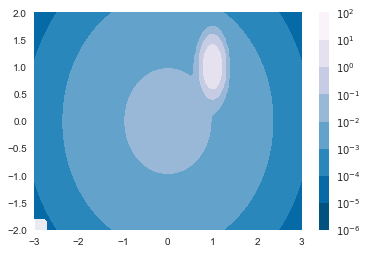

In [137]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import colors, ticker, cm
from matplotlib.mlab import bivariate_normal

N = 100
x = np.linspace(-3.0, 3.0, N)
y = np.linspace(-2.0, 2.0, N)

X, Y = np.meshgrid(x, y)

# A low hump with a spike coming out of the top right.
# Needs to have z/colour axis on a log scale so we see both hump and spike.
# linear scale only shows the spike.
z = (bivariate_normal(X, Y, 0.1, 0.2, 1.0, 1.0)
     + 0.1 * bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0))

# Put in some negative values (lower left corner) to cause trouble with logs:
z[:5, :5] = -1

# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
z = ma.masked_where(z <= 0, z)


# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)

# Alternatively, you can manually set the levels
# and the norm:
#lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
#levs = np.power(10, lev_exp)
#cs = P.contourf(X, Y, z, levs, norm=colors.LogNorm())

# The 'extend' kwarg does not work yet with a log scale.

cbar = fig.colorbar(cs)

plt.show()

In [138]:
z

masked_array(data =
 [[-- -- -- ..., 3.4169675622506574e-05 2.8646464519576396e-05
  2.392797792004706e-05]
 [-- -- -- ..., 3.701526557267341e-05 3.1032091250285686e-05
  2.5920657459921045e-05]
 [-- -- -- ..., 4.003242543844127e-05 3.35615552112394e-05
  2.8033482160012526e-05]
 ..., 
 [2.80334821600125e-05 3.356155521123936e-05 4.003242543844123e-05 ...,
  4.003242543844123e-05 3.356155521123936e-05 2.80334821600125e-05]
 [2.5920657459921024e-05 3.103209125028566e-05 3.701526557267338e-05 ...,
  3.701526557267338e-05 3.103209125028566e-05 2.5920657459921024e-05]
 [2.392797792004706e-05 2.8646464519576396e-05 3.4169675622506574e-05 ...,
  3.4169675622506574e-05 2.8646464519576396e-05 2.392797792004706e-05]],
             mask =
 [[ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False Fa